In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Weird triggers

## Loading tables

We have one table with information about each weird trigger. 

In [3]:
weird_trigs = pd.read_csv("out/weird_trigs.csv", delimiter = ','); weird_trigs

,file_id,det_model,quadrant,source,index,ch_id,duration
0,20220304_02,FM1,C,Fe55,303,19,3.532351
1,20220304_02,FM1,C,Fe55,3419,16,5.099878
2,20220304_02,FM1,C,Fe55,3951,22,5.097642
3,20220304_02,FM1,C,Fe55,9818,26,4.608000
4,20220304_02,FM1,C,Fe55,12365,28,4.603509
...,...,...,...,...,...,...,...
3557,20220308_06,PFM,C,Cs137,175581,14,4.089351
3558,20220308_06,PFM,C,Cs137,176745,0,4.605774
3559,20220308_06,PFM,C,Cs137,178530,11,4.596918
3560,20220308_06,PFM,C,Cs137,178590,21,2.542268


And one table reporting total acquisitions per datafile, as well as the total number of weird triggers.

In [4]:
obs = pd.read_csv("out/obs.csv", delimiter = ','); obs

,file_id,det_model,quadrant,source,tot_acq,weird_acq
0,20220304_02,FM1,C,Fe55,181540,62
1,20220304_03,FM1,C,Fe55,192424,74
2,20220304_04,FM1,C,Cd109,225880,106
3,20220304_06,FM1,C,Cd109,211069,87
4,20220304_07,FM1,C,Cs137,169995,87
5,20220304_08,FM1,C,Cs137,170296,80
6,20220304_09,FM1,C,Cs137,173533,74
7,20220301_01,FM1,A,Fe55,294282,129
8,20220301_02,FM1,A,Fe55,293233,115
9,20220301_03,FM1,A,Cs137,235271,203


## Weird trigger counts

We got weird triggers on all detectors (FM1, PFM)  with similar frequencies.

In [44]:
for model in ['PFM', 'FM1']:
    tot = np.sum(obs[obs['det_model'] == model]['tot_acq']); print("tot acquisition", model, ": {}".format(tot))
    weird = np.sum(obs[obs['det_model'] == model]['weird_acq']); print("tot weird triggers", model, ": {}".format(weird))
    print("\tweird to total obs. frequency: {:.4f}\n".format(weird/tot))

tot acquisition PFM : 3142671
tot weird triggers PFM : 1903
	weird to total obs. frequency: 0.0006

tot acquisition FM1 : 3261441
tot weird triggers FM1 : 1659
	weird to total obs. frequency: 0.0005



Suppose these events being due to a follow-up photon reaching one of the $32$ detectors while mux is cycling over it.
The probability of this event taking place is $P = P_a\cdot P_b$, where:
* $P_a$ is the probability of catching the follow-up photon in the mux window, i.e. the exponential cumulative distribution value at window length $P_a = 1 - e^{-\lambda x}$ where $\lambda \sim 300$ s$^{-1}$ is the event rate and $x = 320$  $\mu$s.
* $P_b$ is $1/32$. 

In [45]:
from scipy.stats import expon

rate = 300 # events per second
mux_dur = 320*10**-6; print('expect {:.3f} events per mux duration'.format(rate*mux_dur))
prob = expon(scale = 1/rate).cdf(mux_dur)/32; print('prob of follow-up photon = {:.4f}'.format(prob))

expect 0.096 events per mux duration
prob of follow-up photon = 0.0029


The frequency of weird triggers we observed is 4-5 time smaller than the theoretical value.

There are a few reason to expect a smaller observed frequency: 
1. we have a number of channel discriminators turned off; 
2. the event may happen over the same channel which trigger in first place, a case in which I suspect the follow-up photon would go undetected; 
3. finite pulse shaping time means that a 'late' follow-up photon could not reach peak and trigger even if mux is cycling over it; 
4. we may be missing weird triggers due to the particular (bad) technique we employ to select them. 

On the other hand we have some probability that more than two events are observed in a single mux bin but it should be safely negligible (scales with powers of $P_b$). 


Some plots:

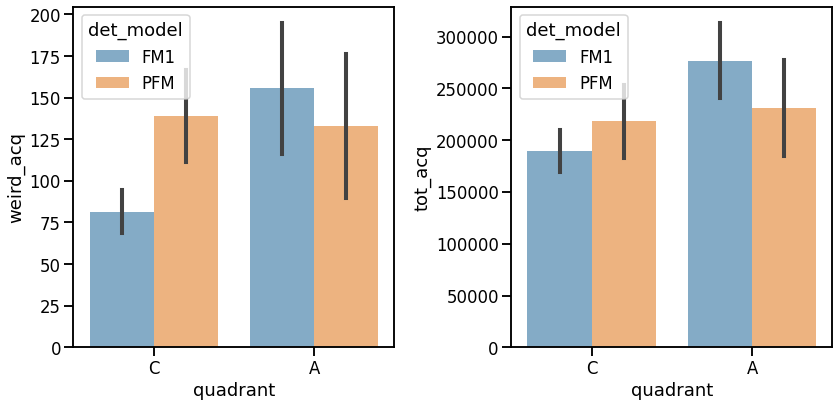

In [40]:
with sns.plotting_context("talk"):
    fig, ax = plt.subplots(1,2, figsize = (12,6))
    sns.barplot(
        data=obs,
        x="quadrant", y="weird_acq", hue="det_model",
        ci="sd",alpha=.6, ax = ax[0]
    )
    sns.barplot(
        data=obs,
        x="quadrant", y="tot_acq", hue="det_model",
        ci="sd",alpha=.6, ax = ax[1]
    )
    plt.tight_layout()

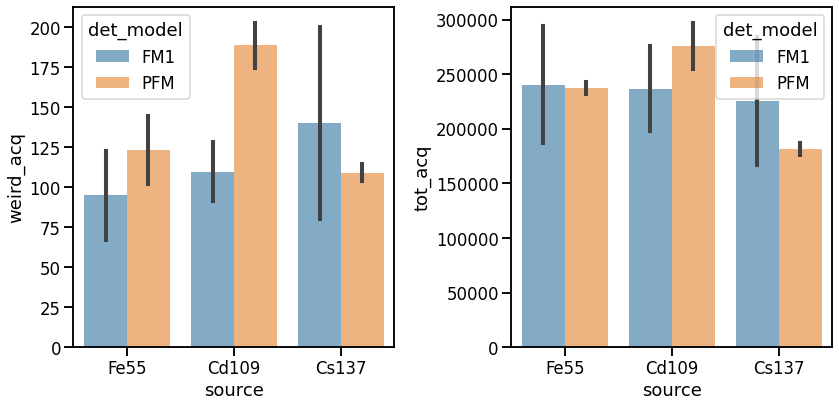

In [41]:
with sns.plotting_context("talk"):
    fig, ax = plt.subplots(1,2, figsize = (12,6))
    sns.barplot(
        data=obs,
        x="source", y="weird_acq", hue="det_model",
        ci="sd",alpha=.6, ax = ax[0]
    )
    sns.barplot(
        data=obs,
        x="source", y="tot_acq", hue="det_model",
        ci="sd",alpha=.6, ax = ax[1]
    )
    plt.tight_layout()

## Duration

Weird trigger duration was estimated integrating over the channel trig mux out, then dividing by the trigger mux out maximum. Durations are nearly gaussian distributed, with peak around 4 us. The fact that no weird trigger longer than 7 us is observed could be explained through the finite pulse shaping time? I suspect that somewhere in this plot (maybe the low-duration end) selection effects must be apparent.

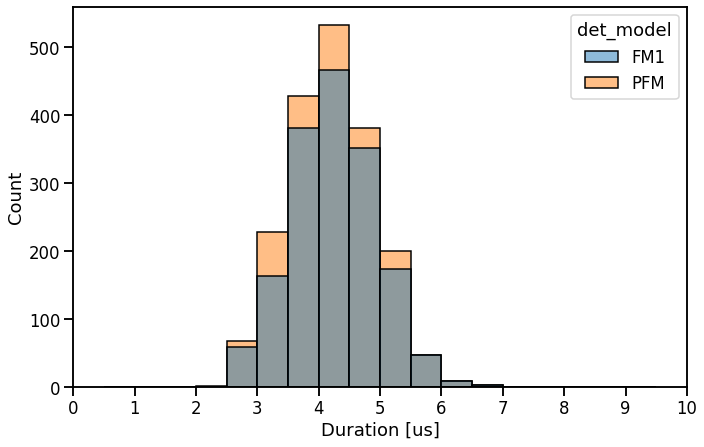

In [84]:
with sns.plotting_context("talk"):
    plt.figure(figsize = (11,7))
    sns.histplot(data = weird_trigs, x='duration', bins = np.arange(0.5,10,0.5), hue = 'det_model')
    plt.xticks( np.arange(0,11))
    plt.xlabel("Duration [us]")

## Channel ID

Across channels weird trigger distribution is (sort of) random. Holes match channels off discriminator patterns. PFM quadrant C had anomalous rate of weird triggers happening on ch28, which was noisy during acquisitions.

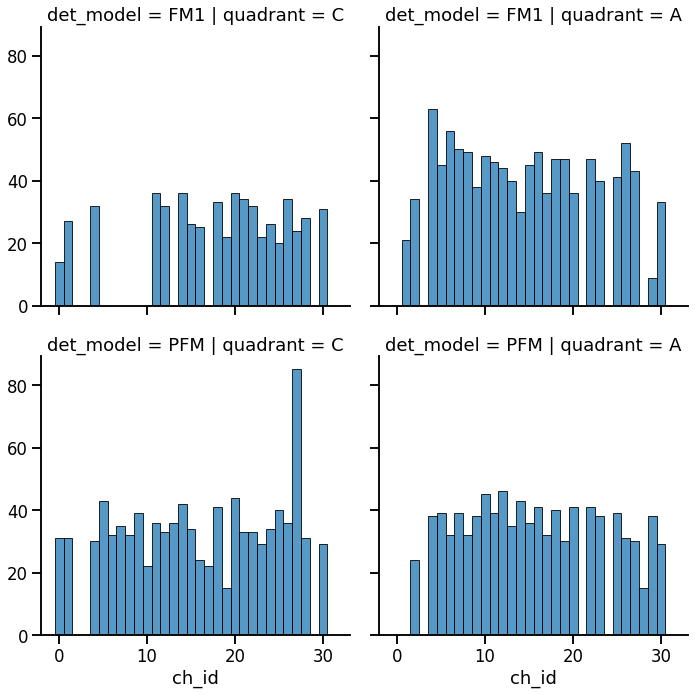

In [97]:
with sns.plotting_context("talk"):
    g = sns.FacetGrid(weird_trigs, col="quadrant", row = 'det_model', height = 5)
    g.map(sns.histplot, "ch_id",  bins = np.arange(-0.5,32.5))
    plt.show()